## Imports 

In [82]:
import geopandas as gpd
import pandas as pd
import h3 
import shapely
import geojson

In [83]:
import sys, os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

from modules.config import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
land_use_flexzone = pd.read_pickle("../00_data/processed/land_use_flexzone.pkl")
land_use_flexzone

,geometry,class_2018
0,"POLYGON ((51.25573 12.37944, 51.25572 12.37906...",Discontinuous dense urban fabric (S.L. : 50% -...
1,"POLYGON ((51.32675 12.28788, 51.32606 12.28668...",Discontinuous dense urban fabric (S.L. : 50% -...
2,"POLYGON ((51.27010 12.36293, 51.26951 12.36298...",Discontinuous dense urban fabric (S.L. : 50% -...
3,"POLYGON ((51.30811 12.43117, 51.30813 12.43117...","Industrial, commercial, public, military and p..."
4,"POLYGON ((51.33568 12.38648, 51.33591 12.38532...",Continuous urban fabric (S.L. : > 80%)
...,...,...
7310,"POLYGON ((51.39093 12.31474, 51.39170 12.31463...",Sports and leisure facilities
7311,"POLYGON ((51.39186 12.31176, 51.39179 12.31350...",Sports and leisure facilities
7312,"POLYGON ((51.38517 12.35545, 51.38508 12.35522...",Sports and leisure facilities
7313,"POLYGON ((51.36356 12.40752, 51.36355 12.40752...",Sports and leisure facilities


In [85]:
trips_grouped = pd.read_pickle(TRIPS_GROUPED_SPATIAL_PATH)
trips_grouped.reset_index(inplace=True)
trips_grouped

,start_hex_id,end_hex_id,demand
0,881f1a140bfffff,881f1a1601fffff,1
1,881f1a140bfffff,881f1a1607fffff,2
2,881f1a140bfffff,881f1a1643fffff,2
3,881f1a140bfffff,881f1a165bfffff,1
4,881f1a140bfffff,881f1a8ca5fffff,1
...,...,...,...
10313,881f1abb6bfffff,881f1a8cdbfffff,1
10314,881f1abb6dfffff,881f1a8cabfffff,1
10315,881f1abb6dfffff,881f1a8cdbfffff,2
10316,881f1abb6dfffff,881f1a8eb3fffff,2


## Build Dataframe containing all relevant hexagons

In [86]:
#extract hexagons ids from trip dataframe and remove duplicates
hexagons = trips_grouped["start_hex_id"].append(trips_grouped["end_hex_id"], ignore_index=True)
hexagons = hexagons.drop_duplicates()
hexagons = pd.DataFrame(hexagons,columns=["hexagon_id"])
hexagons

C:\Users\annes\AppData\Local\Temp\ipykernel_18460\2513043964.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hexagons = trips_grouped["start_hex_id"].append(trips_grouped["end_hex_id"], ignore_index=True)


,hexagon_id
0,881f1a140bfffff
6,881f1a1441fffff
15,881f1a1443fffff
40,881f1a1445fffff
42,881f1a1447fffff
...,...
17034,881f1abb69fffff
17692,881f1a8c15fffff
18180,881f1a8dabfffff
18255,881f1a1745fffff


In [87]:
from shapely.geometry import Polygon
from shapely.geometry import Point

#create polygon geometries from hexagon ids
hexagons['geometry'] = hexagons["hexagon_id"].apply(lambda x: h3.h3_to_geo_boundary(h=x, geo_json=True))
# turn to Point
hexagons['geometry'] = hexagons['geometry'].apply(lambda x: [Point(x,y) for [x,y] in x])
# turn to Polygon
hexagons['geometry'] = hexagons['geometry'].apply(lambda x: Polygon([[poly.x, poly.y] for poly in x]))
hexagons

,hexagon_id,geometry
0,881f1a140bfffff,POLYGON ((12.409552889251133 51.26751951727374...
6,881f1a1441fffff,POLYGON ((12.381287079952044 51.27809335046796...
15,881f1a1443fffff,"POLYGON ((12.39385660146669 51.27646228548258,..."
40,881f1a1445fffff,POLYGON ((12.371848074570075 51.27241480724645...
42,881f1a1447fffff,"POLYGON ((12.384416322481192 51.2707845084337,..."
...,...,...
17034,881f1abb69fffff,"POLYGON ((12.3846795342948 51.408676686045105,..."
17692,881f1a8c15fffff,POLYGON ((12.293349646664058 51.37220119621348...
18180,881f1a8dabfffff,"POLYGON ((12.283883486587005 51.311375929945, ..."
18255,881f1a1745fffff,"POLYGON ((12.28387111424977 51.28378589913364,..."


<AxesSubplot:>

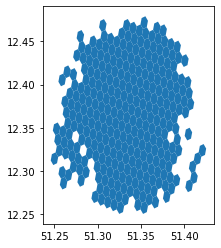

In [88]:
#switch coordinates and plot hexagons
hexagons=  gpd.GeoDataFrame(hexagons)
hexagons.geometry = hexagons.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
hexagons.plot()

## Transform land use categories to numeric values

In [89]:
#rename column
land_use_flexzone.rename(columns={"class_2018":"land_use"}, inplace=True)
land_use_flexzone

,geometry,land_use
0,"POLYGON ((51.25573 12.37944, 51.25572 12.37906...",Discontinuous dense urban fabric (S.L. : 50% -...
1,"POLYGON ((51.32675 12.28788, 51.32606 12.28668...",Discontinuous dense urban fabric (S.L. : 50% -...
2,"POLYGON ((51.27010 12.36293, 51.26951 12.36298...",Discontinuous dense urban fabric (S.L. : 50% -...
3,"POLYGON ((51.30811 12.43117, 51.30813 12.43117...","Industrial, commercial, public, military and p..."
4,"POLYGON ((51.33568 12.38648, 51.33591 12.38532...",Continuous urban fabric (S.L. : > 80%)
...,...,...
7310,"POLYGON ((51.39093 12.31474, 51.39170 12.31463...",Sports and leisure facilities
7311,"POLYGON ((51.39186 12.31176, 51.39179 12.31350...",Sports and leisure facilities
7312,"POLYGON ((51.38517 12.35545, 51.38508 12.35522...",Sports and leisure facilities
7313,"POLYGON ((51.36356 12.40752, 51.36355 12.40752...",Sports and leisure facilities


In [90]:
#create dictionary for land use types
land_use_dict = {"Discontinuous dense urban fabric (S.L. : 50% -  80%)":1, 
                    "Industrial, commercial, public, military and private units":2,
                    "Continuous urban fabric (S.L. : > 80%)":3, 
                    "Sports and leisure facilities":4, 
                    "Green urban areas":5,
                    "Discontinuous medium density urban fabric (S.L. : 30% - 50%)":6,
                    "Arable land (annual crops)":7,
                    "Pastures":8,
                    "Land without current use":9,
                    "Forests":10,
                    "Water":11,
                    "Railways and associated land":12,
                    "Discontinuous low density urban fabric (S.L. : 10% - 30%)":13,
                    "Mineral extraction and dump sites":14,                                                    
                    "Isolated structures":15,                                                               
                    "Herbaceous vegetation associations (natural grassland, moors...)":16,                    
                    "Discontinuous very low density urban fabric (S.L. : < 10%)":17,                          
                    "Construction sites":18,                                                                   
                    "Fast transit roads and associated land":19,                                               
                    "Other roads and associated land":20,                                                       
                    "Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)":21,       
                    "Wetlands":22}
land_use_types = land_use_flexzone["land_use"].unique()
land_use_types

array(['Discontinuous dense urban fabric (S.L. : 50% -  80%)',
       'Industrial, commercial, public, military and private units',
       'Continuous urban fabric (S.L. : > 80%)',
       'Fast transit roads and associated land',
       'Other roads and associated land', 'Railways and associated land',
       'Land without current use', 'Green urban areas',
       'Sports and leisure facilities', 'Arable land (annual crops)',
       'Discontinuous very low density urban fabric (S.L. : < 10%)',
       'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
       'Pastures',
       'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
       'Forests', 'Isolated structures', 'Water',
       'Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)',
       'Construction sites', 'Mineral extraction and dump sites',
       'Herbaceous vegetation associations (natural grassland, moors...)',
       'Wetlands'], dtype=object)

In [91]:
#replace categorical with numerical values for land use types
land_use_flexzone["land_use"] = land_use_flexzone["land_use"].map(land_use_dict)

In [92]:
#take a look at the frequency of land use types in the flexzone
land_use_flexzone["land_use"].value_counts()

1     1936
2     1336
3     1319
4      589
5      554
6      397
7      312
8      263
9      191
10      96
11      86
12      72
13      61
14      22
15      16
16      16
17      12
18      12
19      10
20       9
21       5
22       1
Name: land_use, dtype: int64

## Calculate land use types for each hexagon in percent

In [93]:
#match coordinate reference systems
hexagons = gpd.GeoDataFrame(hexagons, crs= "EPSG:4326")
land_use_flexzone = gpd.GeoDataFrame(land_use_flexzone, crs= "EPSG:4326")

hexagons 

C:\Users\annes\AppData\Local\Temp\ipykernel_18460\2412709466.py:1: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  hexagons = gpd.GeoDataFrame(hexagons, crs= "EPSG:4326")


,hexagon_id,geometry
0,881f1a140bfffff,"POLYGON ((51.26752 12.40955, 51.26319 12.40745..."
6,881f1a1441fffff,"POLYGON ((51.27809 12.38129, 51.27376 12.37918..."
15,881f1a1443fffff,"POLYGON ((51.27646 12.39386, 51.27213 12.39175..."
40,881f1a1445fffff,"POLYGON ((51.27241 12.37185, 51.26809 12.36975..."
42,881f1a1447fffff,"POLYGON ((51.27078 12.38442, 51.26646 12.38231..."
...,...,...
17034,881f1abb69fffff,"POLYGON ((51.40868 12.38468, 51.40436 12.38257..."
17692,881f1a8c15fffff,"POLYGON ((51.37220 12.29335, 51.36788 12.29125..."
18180,881f1a8dabfffff,"POLYGON ((51.31138 12.28388, 51.30705 12.28179..."
18255,881f1a1745fffff,"POLYGON ((51.28379 12.28387, 51.27946 12.28177..."


In [94]:
#map land use to hexagons
result_gdf = gpd.overlay(hexagons , land_use_flexzone , how='intersection')
result_gdf

,hexagon_id,land_use,geometry
0,881f1a140bfffff,20,"POLYGON ((51.26653 12.42098, 51.26602 12.42158..."
1,881f1a1441fffff,20,"MULTIPOLYGON (((51.27284 12.38080, 51.27284 12..."
2,881f1a1443fffff,20,"POLYGON ((51.27624 12.39375, 51.27615 12.39396..."
3,881f1a1445fffff,20,"MULTIPOLYGON (((51.27367 12.37867, 51.27366 12..."
4,881f1a1447fffff,20,"MULTIPOLYGON (((51.27190 12.39215, 51.27192 12..."
...,...,...,...
10520,881f1abb39fffff,3,"POLYGON ((51.38927 12.44534, 51.38910 12.44541..."
10521,881f1abb39fffff,1,"POLYGON ((51.39266 12.45049, 51.39268 12.45042..."
10522,881f1abb39fffff,19,"POLYGON ((51.39166 12.43924, 51.39168 12.43921..."
10523,881f1abb39fffff,8,"POLYGON ((51.39196 12.43874, 51.39195 12.43875..."


In [95]:
#extract area of each hexagon
hexagon_area = hexagons.iloc[0,1].area
hexagon_area


8.677751644264448e-05

In [96]:
#calculate are anbd overlapfor each existing pair of land use and hexagon
result_gdf["area"]= result_gdf.geometry.apply(lambda x: x.area)
result_gdf["overlap"] = result_gdf.area.apply(lambda x: x/hexagon_area)
result_gdf

C:\Users\annes\AppData\Local\Temp\ipykernel_18460\657602839.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  result_gdf["overlap"] = result_gdf.area.apply(lambda x: x/hexagon_area)


,hexagon_id,land_use,geometry,area,overlap
0,881f1a140bfffff,20,"POLYGON ((51.26653 12.42098, 51.26602 12.42158...",4.459969e-08,0.000514
1,881f1a1441fffff,20,"MULTIPOLYGON (((51.27284 12.38080, 51.27284 12...",7.517519e-06,0.086630
2,881f1a1443fffff,20,"POLYGON ((51.27624 12.39375, 51.27615 12.39396...",6.025497e-06,0.069436
3,881f1a1445fffff,20,"MULTIPOLYGON (((51.27367 12.37867, 51.27366 12...",6.903977e-06,0.079560
4,881f1a1447fffff,20,"MULTIPOLYGON (((51.27190 12.39215, 51.27192 12...",5.812368e-07,0.006698
...,...,...,...,...,...
10520,881f1abb39fffff,3,"POLYGON ((51.38927 12.44534, 51.38910 12.44541...",5.406766e-07,0.006231
10521,881f1abb39fffff,1,"POLYGON ((51.39266 12.45049, 51.39268 12.45042...",5.504157e-06,0.063428
10522,881f1abb39fffff,19,"POLYGON ((51.39166 12.43924, 51.39168 12.43921...",5.168134e-07,0.005956
10523,881f1abb39fffff,8,"POLYGON ((51.39196 12.43874, 51.39195 12.43875...",1.754372e-06,0.020217


In [97]:
#checking closely the sum of percentages matches 100%
percentage_check =result_gdf.groupby("hexagon_id")["overlap"].sum()
percentage_check

hexagon_id
881f1a1401fffff    0.896187
881f1a140bfffff    0.831309
881f1a1441fffff    0.999833
881f1a1443fffff    0.999907
881f1a1445fffff    0.999779
                     ...   
881f1abb65fffff    0.999800
881f1abb67fffff    0.999874
881f1abb69fffff    0.999835
881f1abb6bfffff    0.999909
881f1abb6dfffff    0.999780
Name: overlap, Length: 302, dtype: float64

In [107]:
#Some statistics regarding the deviation of the sum of percentages of land use types from 100%
print("Maximum: " ,percentage_check.max())
print("Minimum: " ,percentage_check.min())
print("Mean: " ,percentage_check.mean())
print("Median: " ,percentage_check.median())
print("Standard Deviation: " ,percentage_check.std())


Maximum:  1.0002493215808486
Minimum:  0.109232957782223
Mean:  0.9715566760233811
Median:  0.9996576711919545
Standard Deviation:  0.11774007295457874


In [98]:
#Summing up duplicatwe entries for a specific hexagon and land use type
hexagons_land_use = result_gdf.set_index(["hexagon_id", "land_use"])
hexagons_land_use = pd.DataFrame(hexagons_land_use.groupby(["hexagon_id", "land_use"])["overlap"].sum())
hexagons_land_use

overlap
hexagon_id      land_use          
881f1a1401fffff 10        0.780464
                11        0.061850
                16        0.053872
881f1a140bfffff 5         0.113714
                7         0.000327
...                            ...
881f1abb6dfffff 7         0.201923
                8         0.003448
                12        0.009895
                13        0.005745
                20        0.074076

[2522 rows x 1 columns]

In [100]:
#create columns for each land use type
hexagons_land_use_columns = hexagons_land_use.unstack()
hexagons_land_use_columns.fillna(0, inplace=True)
hexagons_land_use_columns

overlap                                                    \
land_use               1         2         3         4         5         6    
hexagon_id                                                                    
881f1a1401fffff  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
881f1a140bfffff  0.000000  0.000000  0.000000  0.000000  0.113714  0.000000   
881f1a1441fffff  0.000000  0.038661  0.000000  0.142534  0.225712  0.036618   
881f1a1443fffff  0.366876  0.145074  0.000000  0.029229  0.072826  0.080754   
881f1a1445fffff  0.137952  0.306458  0.000000  0.128812  0.000000  0.043621   
...                   ...       ...       ...       ...       ...       ...   
881f1abb65fffff  0.333898  0.104667  0.000000  0.000000  0.000000  0.000000   
881f1abb67fffff  0.000000  0.622313  0.000000  0.000000  0.000000  0.000000   
881f1abb69fffff  0.000000  0.078329  0.000000  0.000000  0.000000  0.000000   
881f1abb6bfffff  0.000652  0.309157  0.000000  0.195273  0.000000  0.000000   
881f1abb6dfffff  0.553720  0.065292  0.013859  0.041810  0.024300  0.005712   

                                                         ...            \
land_use               7         8         9         10  ...        13   
hexagon_id                                               ...             
881f1a1401fffff  0.000000  0.000000  0.000000  0.780464  ...  0.000000   
881f1a140bfffff  0.000327  0.000000  0.000000  0.000000  ...  0.000000   
881f1a1441fffff  0.158930  0.261692  0.000000  0.016507  ...  0.000000   
881f1a1443fffff  0.042152  0.039226  0.010350  0.026167  ...  0.000000   
881f1a1445fffff  0.118355  0.044073  0.021327  0.067390  ...  0.000000   
...                   ...       ...       ...       ...  ...       ...   
881f1abb65fffff  0.054948  0.277805  0.001905  0.000000  ...  0.000000   
881f1abb67fffff  0.002175  0.060230  0.000000  0.016365  ...  0.000000   
881f1abb69fffff  0.108546  0.376598  0.000000  0.000000  ...  0.000000   
881f1abb6bfffff  0.205284  0.097047  0.000000  0.039589  ...  0.000000   
881f1abb6dfffff  0.201923  0.003448  0.000000  0.000000  ...  0.005745   

                                                                             \
land_use               14   15        16   17   18        19        20   21   
hexagon_id                                                                    
881f1a1401fffff  0.000000  0.0  0.053872  0.0  0.0  0.000000  0.000000  0.0   
881f1a140bfffff  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000514  0.0   
881f1a1441fffff  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.086630  0.0   
881f1a1443fffff  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.069436  0.0   
881f1a1445fffff  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.079560  0.0   
...                   ...  ...       ...  ...  ...       ...       ...  ...   
881f1abb65fffff  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.130261  0.0   
881f1abb67fffff  0.000000  0.0  0.080854  0.0  0.0  0.000000  0.108633  0.0   
881f1abb69fffff  0.060955  0.0  0.000000  0.0  0.0  0.289549  0.044208  0.0   
881f1abb6bfffff  0.075224  0.0  0.000000  0.0  0.0  0.049675  0.028009  0.0   
881f1abb6dfffff  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.074076  0.0   

                      
land_use          22  
hexagon_id            
881f1a1401fffff  0.0  
881f1a140bfffff  0.0  
881f1a1441fffff  0.0  
881f1a1443fffff  0.0  
881f1a1445fffff  0.0  
...              ...  
881f1abb65fffff  0.0  
881f1abb67fffff  0.0  
881f1abb69fffff  0.0  
881f1abb6bfffff  0.0  
881f1abb6dfffff  0.0  

[302 rows x 22 columns]